# Perceptron Implementation for Diabetes Prediction

## 1. Data Loading and Preprocessing


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:

def get_data(data):
    data = load_svmlight_file(data)
    return data[0], data[1]
features, target = get_data("/Users/deliciamagdaline/Desktop/BDAP/Aml/deep learning/Data/Diabetes dataset.txt")
print(f'Unique values in the target are {np.unique(target)}, with {len(target)} observations')
features = features.toarray()


# Convert target to -1 and 1
target = np.where(target == 1, 1, -1)

# Define feature names
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Unique values in the target are [-1.  1.], with 768 observations


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# Replace 0 values with NaN for specific features
zero_replacement_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for i, feature in enumerate(feature_names):
    if feature in zero_replacement_features:
        features[:, i] = np.where(features[:, i] == 0, np.nan, features[:, i])

# Impute NaN values
imputer = SimpleImputer(strategy='median')
features = imputer.fit_transform(features)


2. Data Splitting
pythonCopyfrom sklearn.model_selection import train_test_split


In [27]:
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(features, target)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(491, 8) (491,) (123, 8) (123,) (154, 8) (154,)


3. Exploratory Data Analysis (EDA)

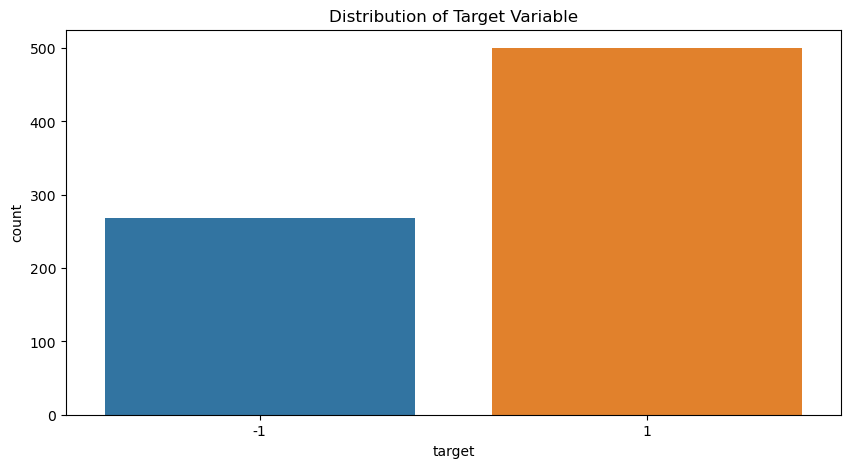

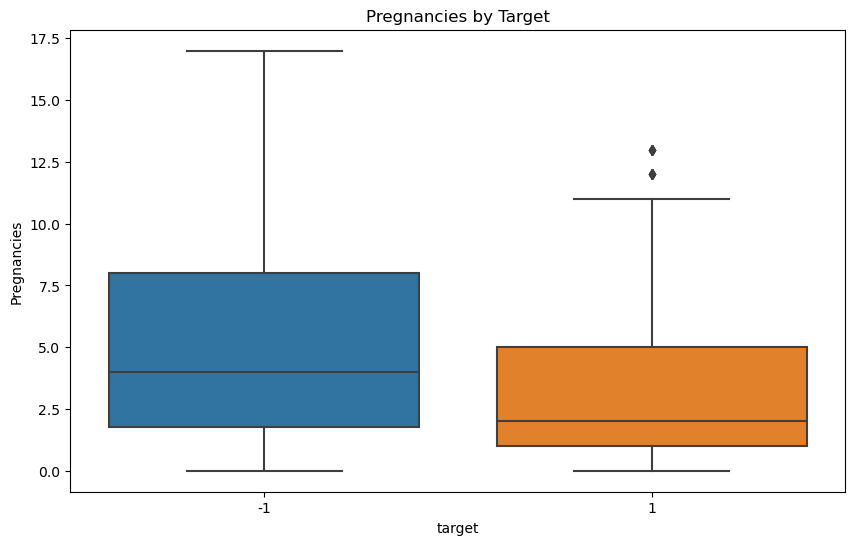

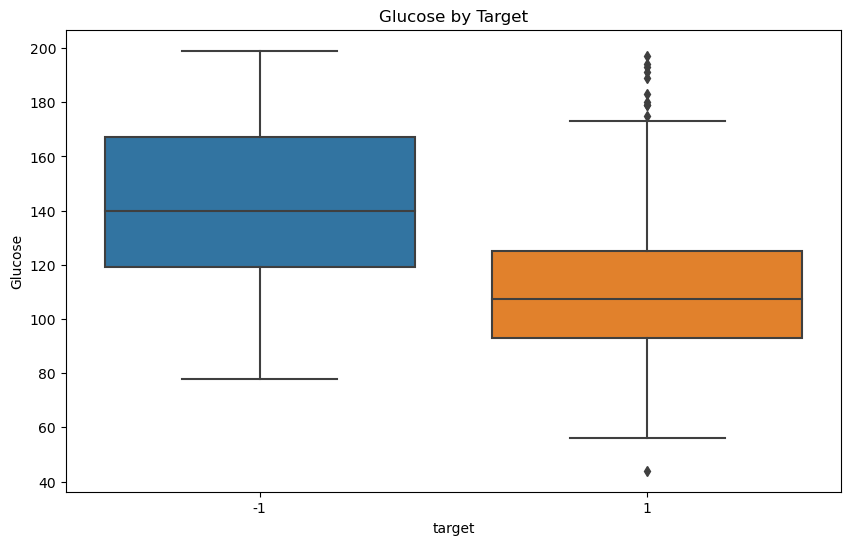

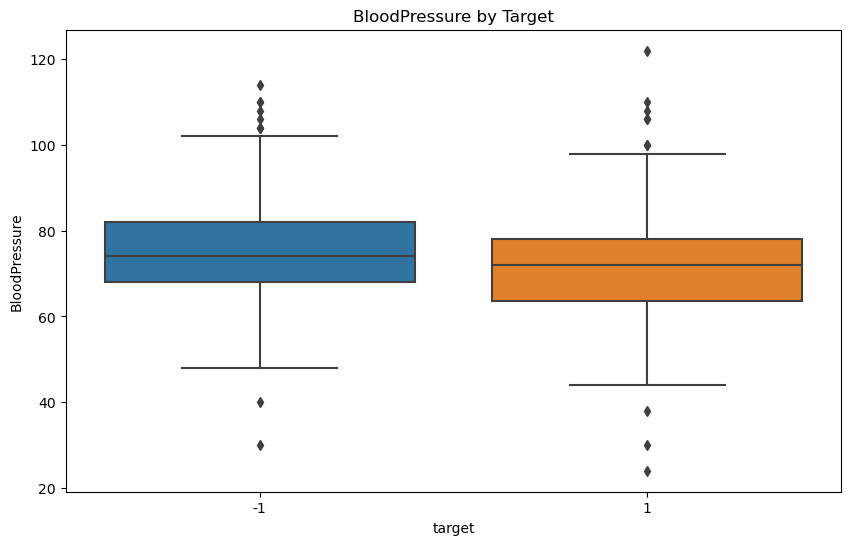

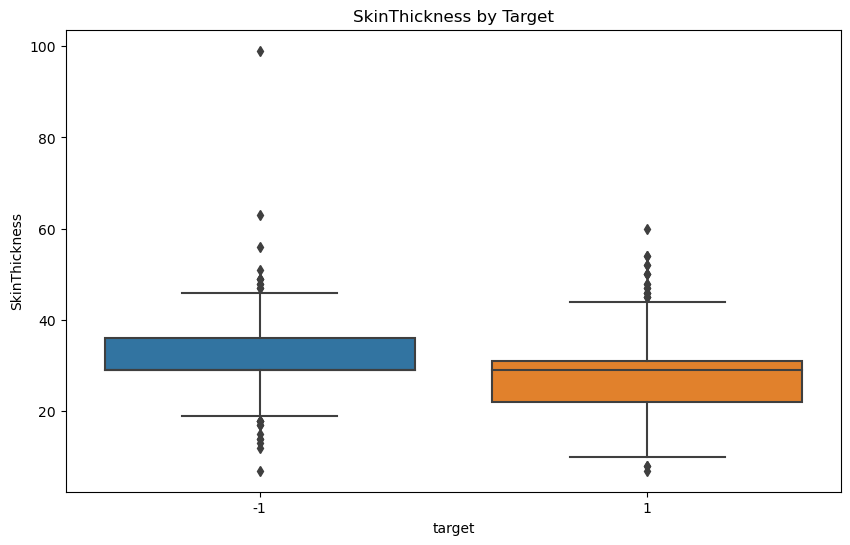

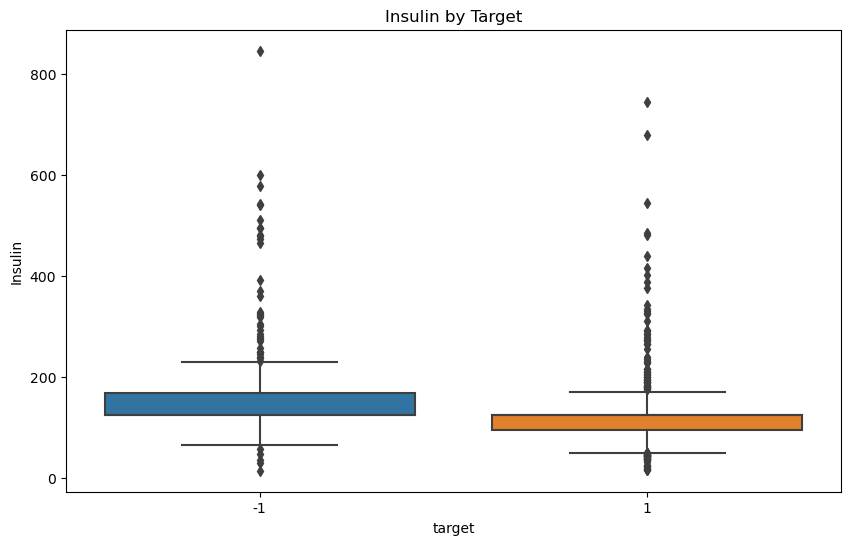

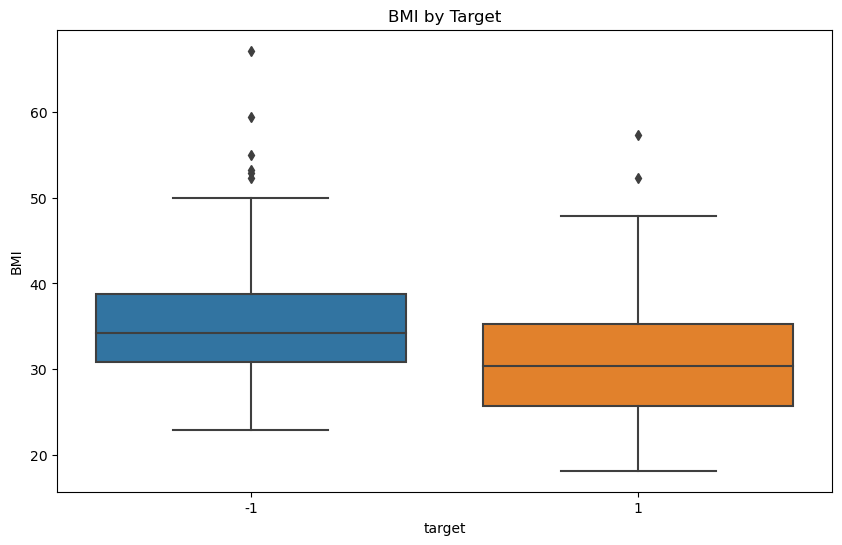

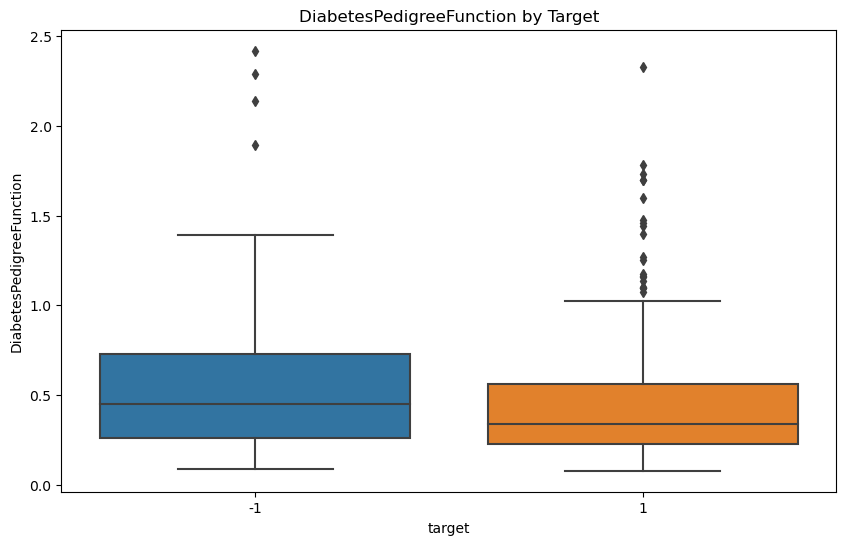

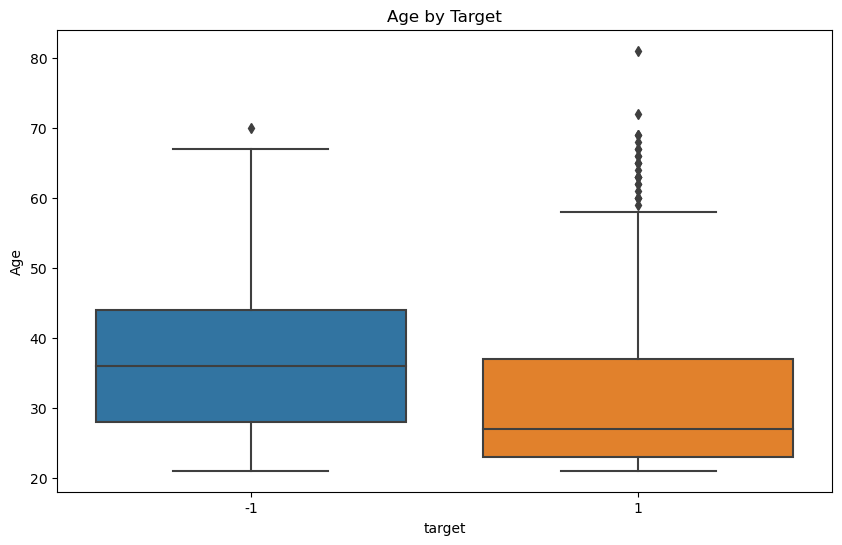

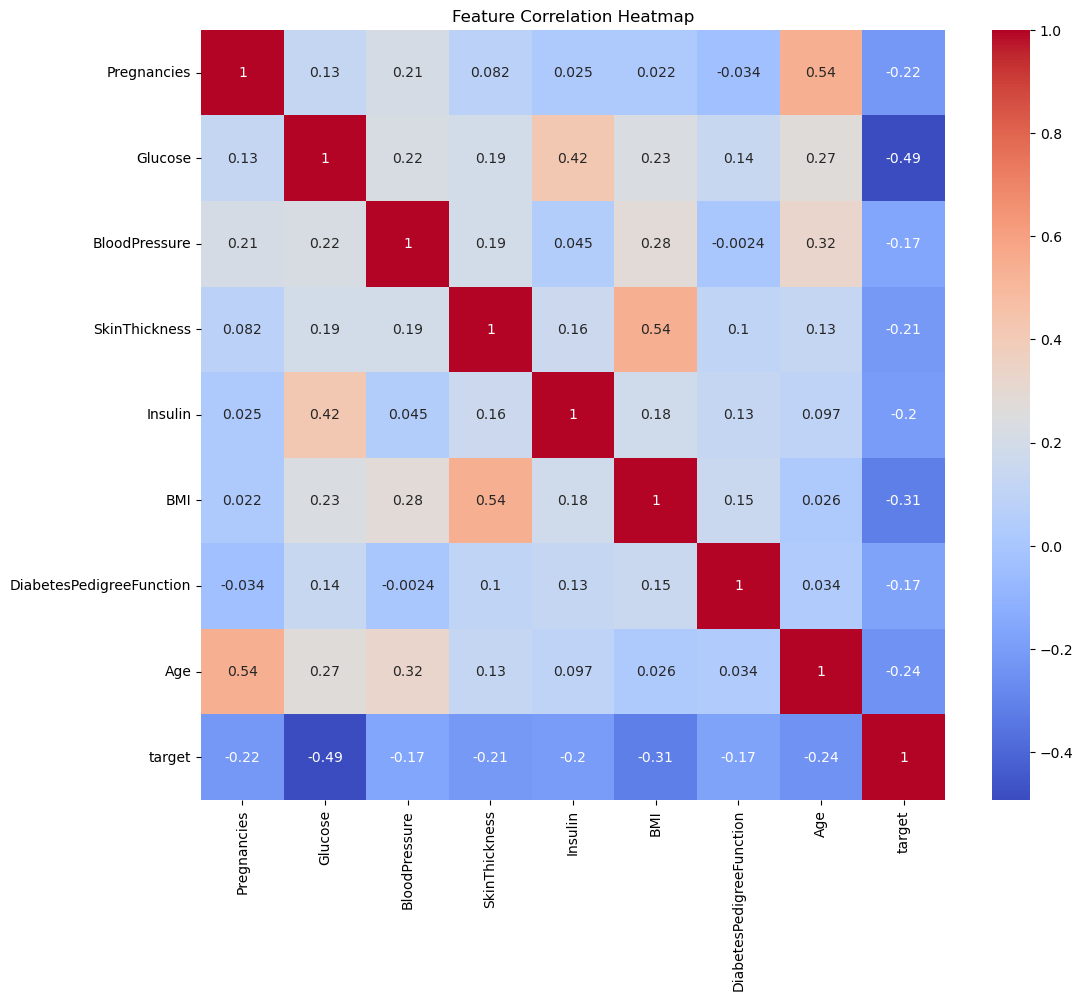

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age      target  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.302083  
std      6.875177                  0.331329   11.760232    0.953903  
min     18.200001                  

In [28]:


import seaborn as sns

def perform_eda(X, y, feature_names):
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y
    
    plt.figure(figsize=(10, 5))
    sns.countplot(x='target', data=df)
    plt.title('Distribution of Target Variable')
    plt.show()
    
    for feature in feature_names:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y=feature, data=df)
        plt.title(f'{feature} by Target')
        plt.show()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.show()
    
    print(df.describe())

perform_eda(features, target, feature_names)

# 4. Perceptron Implementation

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from scipy.stats import uniform, randint

class Perceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights_ = None
        self.bias_ = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.weights_ = np.random.rand(X.shape[1])
        self.bias_ = np.random.rand(1)[0]

        for _ in range(self.n_iterations):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                
                y_pred = self._predict(X_batch)
                error = y_batch - y_pred
                
                self.weights_ += self.learning_rate * np.dot(X_batch.T, error) / self.batch_size
                self.bias_ += self.learning_rate * np.mean(error)

        return self

    def _predict(self, X):
        linear_output = np.dot(X, self.weights_) + self.bias_
        return np.where(linear_output >= 0, 1, -1)

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self._predict(X)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

def train_perceptron(X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
    model = Perceptron(learning_rate=learning_rate, n_iterations=epochs, batch_size=batch_size)
    
    train_acc_list = []
    val_acc_list = []
    best_val_accuracy = 0
    patience = 20
    no_improvement_count = 0
    best_weights = None
    best_bias = None

    for epoch in range(epochs):
        model.fit(X_train, y_train)
        
        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_val, y_val)
        
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            no_improvement_count = 0
            best_weights = model.weights_.copy()
            best_bias = model.bias_
        else:
            no_improvement_count += 1
            
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.weights_ = best_weights
            model.bias_ = best_bias
            break
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

    return model, train_acc_list, val_acc_list

# 5. Experiments



### 5.1Batch Size Analysis


Training with batch size: 1
Epoch 0: Train Accuracy = 0.6762, Validation Accuracy = 0.6504
Early stopping at epoch 35

Training with batch size: 32
Epoch 0: Train Accuracy = 0.5784, Validation Accuracy = 0.5528
Early stopping at epoch 25

Training with batch size: 64
Epoch 0: Train Accuracy = 0.4664, Validation Accuracy = 0.4309
Early stopping at epoch 29


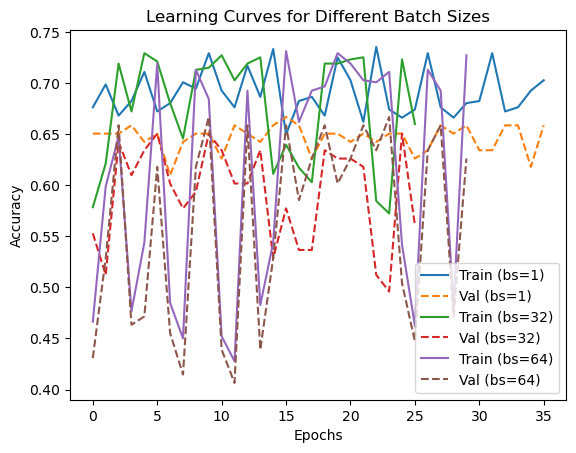

In [30]:
batch_sizes = [1, 32, 64]
for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    model, train_acc, val_acc = train_perceptron(X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=bs)
    plt.plot(train_acc, label=f'Train (bs={bs})')
    plt.plot(val_acc, label=f'Val (bs={bs})', linestyle='--')

plt.title('Learning Curves for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.2 Shuffling Effect

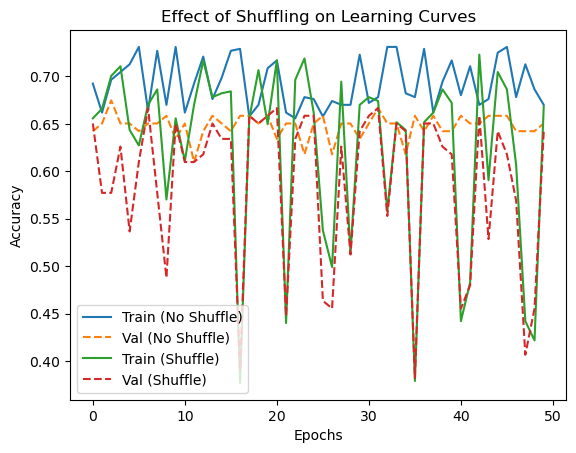

In [31]:
def train_with_shuffle(X_train, y_train, X_val, y_val, shuffle=False):
    model = Perceptron(learning_rate=0.001, n_iterations=50, batch_size=1)
    train_acc_list = []
    val_acc_list = []

    for _ in range(50):
        if shuffle:
            X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
        model.fit(X_train, y_train)
        train_acc_list.append(model.score(X_train, y_train))
        val_acc_list.append(model.score(X_val, y_val))

    return train_acc_list, val_acc_list

train_acc_no_shuffle, val_acc_no_shuffle = train_with_shuffle(X_train, y_train, X_val, y_val, shuffle=False)
train_acc_shuffle, val_acc_shuffle = train_with_shuffle(X_train, y_train, X_val, y_val, shuffle=True)

plt.plot(train_acc_no_shuffle, label='Train (No Shuffle)')
plt.plot(val_acc_no_shuffle, label='Val (No Shuffle)', linestyle='--')
plt.plot(train_acc_shuffle, label='Train (Shuffle)')
plt.plot(val_acc_shuffle, label='Val (Shuffle)', linestyle='--')
plt.title('Effect of Shuffling on Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.3 Hyperparameter Tuning

In [32]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    learning_rates = [ 0.0001,0.001, 0.01]
    batch_sizes = [1, 32, 64]
    n_iterations_values = [100, 500, 1000]
    
    best_val_acc = 0
    best_params = {}

    for lr in learning_rates:
        for bs in batch_sizes:
            for n_iter in n_iterations_values:
                model, _, val_acc = train_perceptron(X_train, y_train, X_val, y_val, 
                                                     epochs=n_iter, 
                                                     learning_rate=lr, 
                                                     batch_size=bs)
                if val_acc[-1] > best_val_acc:
                    best_val_acc = val_acc[-1]
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'n_iterations': n_iter,
                    }
    
    print("Best parameters:", best_params)
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return best_params

best_params = hyperparameter_tuning(X_train, y_train, X_val, y_val)

Epoch 0: Train Accuracy = 0.7271, Validation Accuracy = 0.6341
Early stopping at epoch 26
Epoch 0: Train Accuracy = 0.7332, Validation Accuracy = 0.6667
Early stopping at epoch 24
Epoch 0: Train Accuracy = 0.6497, Validation Accuracy = 0.6667
Early stopping at epoch 21
Epoch 0: Train Accuracy = 0.6171, Validation Accuracy = 0.5203
Early stopping at epoch 32
Epoch 0: Train Accuracy = 0.7271, Validation Accuracy = 0.6423
Early stopping at epoch 24
Epoch 0: Train Accuracy = 0.7189, Validation Accuracy = 0.6585
Early stopping at epoch 20
Epoch 0: Train Accuracy = 0.6497, Validation Accuracy = 0.5691
Early stopping at epoch 42
Epoch 0: Train Accuracy = 0.7291, Validation Accuracy = 0.6016
Early stopping at epoch 53
Epoch 0: Train Accuracy = 0.5540, Validation Accuracy = 0.5203
Early stopping at epoch 61
Epoch 0: Train Accuracy = 0.6864, Validation Accuracy = 0.6504
Early stopping at epoch 24
Epoch 0: Train Accuracy = 0.6762, Validation Accuracy = 0.6504
Early stopping at epoch 35
Epoch 0: T

### 5.4 Weight and Bias Analysis


Epoch 0: Train Accuracy = 0.6864, Validation Accuracy = 0.6585
Early stopping at epoch 27


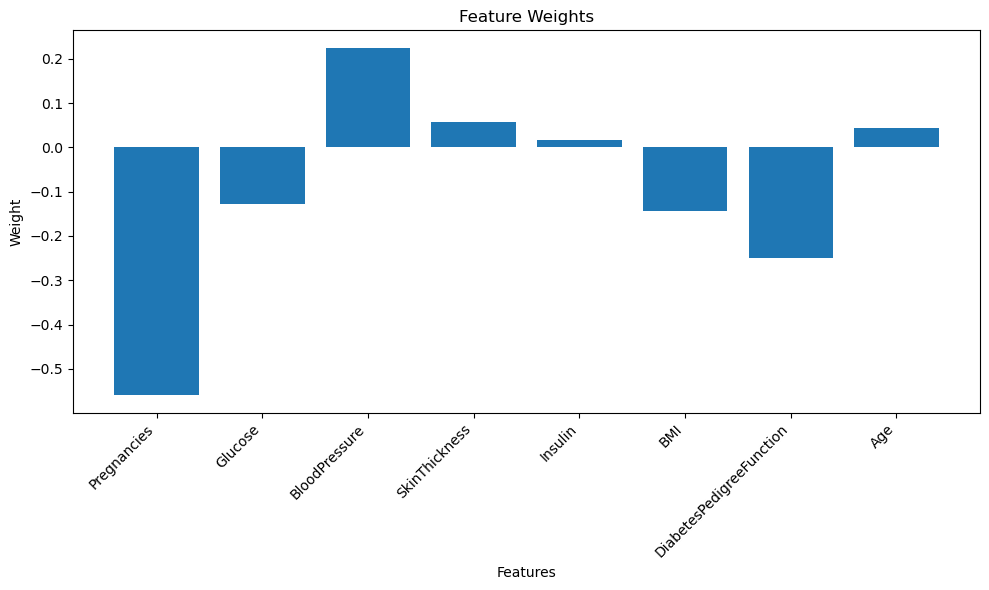

Bias: 1.8612


In [33]:
# Train the model with the best parameters
best_model, _, _ = train_perceptron(X_train, y_train, X_val, y_val, 
                                    epochs=best_params['n_iterations'],
                                    learning_rate=best_params['learning_rate'],
                                    batch_size=best_params['batch_size'],
                                    )

# Plot the weights
def plot_weights(model, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, model.weights_)
    plt.title('Feature Weights')
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_weights(best_model, feature_names)
print(f"Bias: {best_model.bias_:.4f}")

### 5.5 Early Stopping


Epoch 0: Train Accuracy = 0.7251, Validation Accuracy = 0.6504
Early stopping at epoch 9


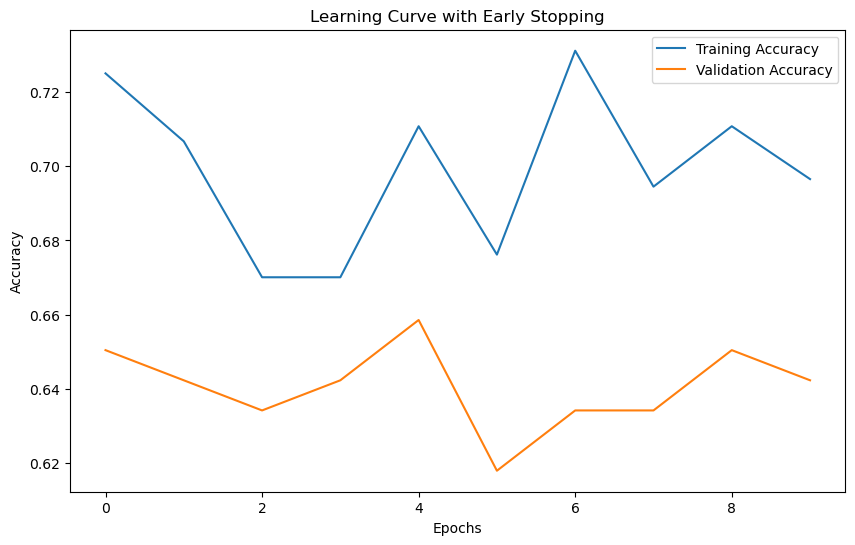

In [34]:

def train_with_early_stopping(X_train, y_train, X_val, y_val, patience=5):
    model = Perceptron(learning_rate=0.01, n_iterations=1000, batch_size=32)
    
    best_val_accuracy = 0
    patience_counter = 0
    training_accuracy = []
    validation_accuracy = []
    
    for epoch in range(1000):
        model.fit(X_train, y_train)
        
        train_acc = model.score(X_train, y_train)
        val_acc = model.score(X_val, y_val)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")
    
    return model, training_accuracy, validation_accuracy

model, train_acc, val_acc = train_with_early_stopping(X_train, y_train, X_val, y_val)

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Learning Curve with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.6 Robustness Analysis


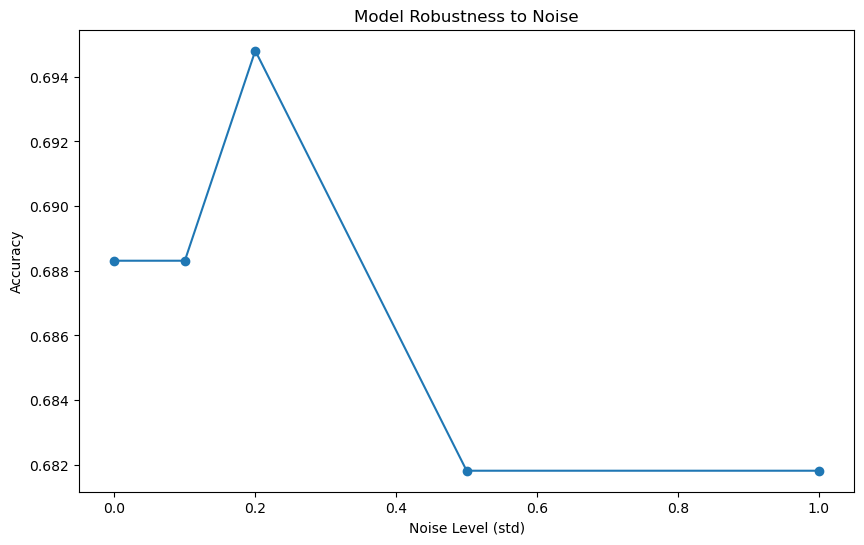

In [35]:
def analyze_noise_robustness(model, X, y, noise_levels):
    accuracies = []
    for noise in noise_levels:
        X_noisy = X + np.random.normal(0, noise, X.shape)
        acc = model.score(X_noisy, y)
        accuracies.append(acc)
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, accuracies, marker='o')
    plt.title('Model Robustness to Noise')
    plt.xlabel('Noise Level (std)')
    plt.ylabel('Accuracy')
    plt.show()

noise_levels = [0, 0.1, 0.2, 0.5, 1.0]
analyze_noise_robustness(best_model, X_test, y_test, noise_levels)

### 5.7 Polynomial Features


Epoch 0: Train Accuracy = 0.6823, Validation Accuracy = 0.6016
Early stopping at epoch 22


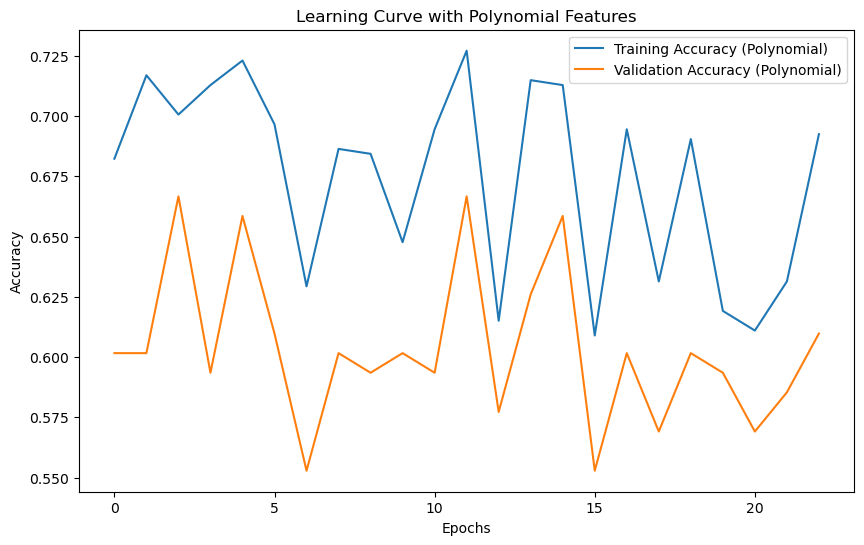

Original Features Test Accuracy: 0.6883
Polynomial Features Test Accuracy: 0.6558


In [36]:
from sklearn.preprocessing import PolynomialFeatures

def generate_polynomial_features(X, degree=2):
    original_feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Generate feature names
    feature_names = poly.get_feature_names_out(original_feature_names)
    
    return X_poly, feature_names

X_poly, poly_feature_names = generate_polynomial_features(features, degree=2)

# Split the polynomial features data
X_train_poly, X_val_poly, X_test_poly, y_train, y_val, y_test = split_data(X_poly, target)

# Train a model with polynomial features
poly_model, poly_train_acc, poly_val_acc = train_perceptron(X_train_poly, y_train, X_val_poly, y_val, epochs=50, learning_rate=0.001, batch_size=32)

plt.figure(figsize=(10, 6))
plt.plot(poly_train_acc, label='Training Accuracy (Polynomial)')
plt.plot(poly_val_acc, label='Validation Accuracy (Polynomial)')
plt.title('Learning Curve with Polynomial Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compare performance
print(f"Original Features Test Accuracy: {best_model.score(X_test, y_test):.4f}")
print(f"Polynomial Features Test Accuracy: {poly_model.score(X_test_poly, y_test):.4f}")

# 6. Model Evaluation


Test Accuracy: 0.6883

Classification Report:
              precision    recall  f1-score   support

          -1       0.56      0.54      0.55        54
           1       0.75      0.77      0.76       100

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



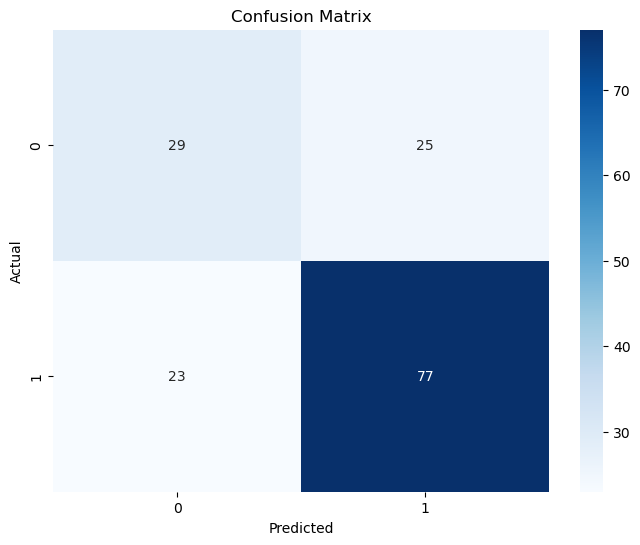

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_acc = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [38]:
from sklearn.datasets import make_classification

# Generate a linearly separable dummy dataset
def create_dummy_dataset():
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, flip_y=0, class_sep=2)
    y = np.where(y == 0, -1, 1)  # Convert class labels to -1 and 1 for compatibility with Perceptron
    return X, y

# Train Perceptron on the dummy dataset
def test_dummy_perceptron():
    X_dummy, y_dummy = create_dummy_dataset()
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_dummy, y_dummy)  # Using the same split function

    # Using your existing Perceptron class
    model, train_acc_list, val_acc_list = train_perceptron(X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.001, batch_size=32)
    
    # Evaluate on the test set
    test_acc = model.score(X_test, y_test)
    print(f"Dummy Dataset Test Accuracy: {test_acc:.4f}")
    
    return model, train_acc_list, val_acc_list

# Run the test
dummy_model, train_acc_list, val_acc_list = test_dummy_perceptron()


Epoch 0: Train Accuracy = 0.5000, Validation Accuracy = 0.5000
Early stopping at epoch 22
Dummy Dataset Test Accuracy: 1.0000


## 7. Additional Experiments


#### 7.1 Feature Importance

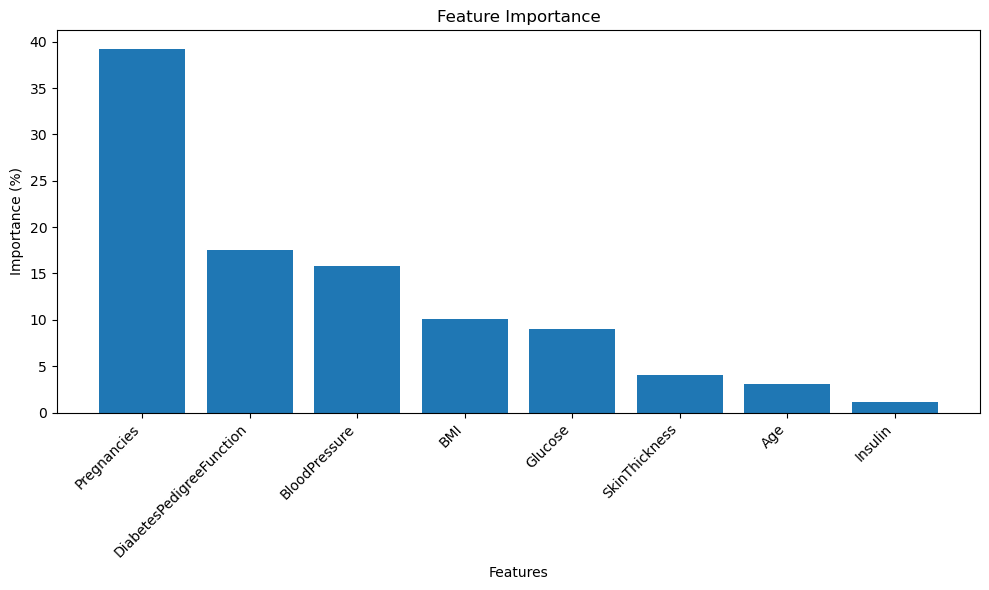

Feature Importance:
Pregnancies: 39.26%
DiabetesPedigreeFunction: 17.52%
BloodPressure: 15.78%
BMI: 10.11%
Glucose: 9.02%
SkinThickness: 4.06%
Age: 3.08%
Insulin: 1.19%


In [39]:
def analyze_feature_importance(model, feature_names):
    importance = np.abs(model.weights_)
    importance = 100.0 * (importance / np.sum(importance))
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), [i[1] for i in feature_importance])
    plt.xticks(range(len(importance)), [i[0] for i in feature_importance], rotation=45, ha='right')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance (%)')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

importance = analyze_feature_importance(best_model, feature_names)
print("Feature Importance:")
for feature, imp in importance:
    print(f"{feature}: {imp:.2f}%")

7.2 ROC Curve Analysis


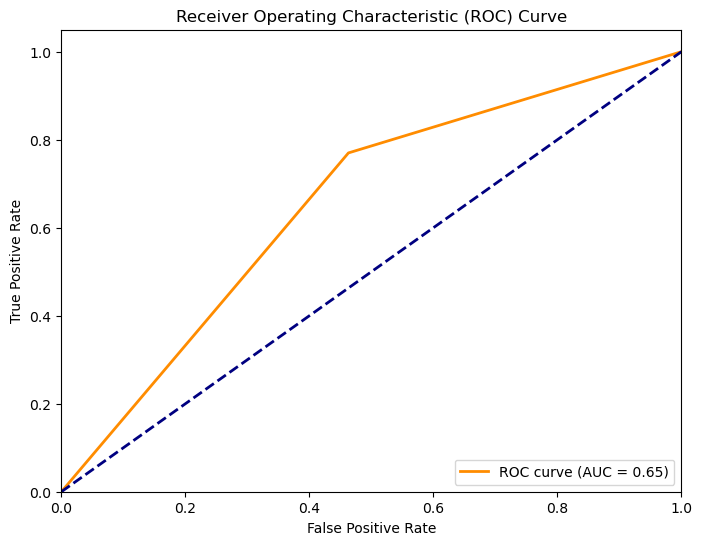

AUC-ROC Score: 0.6535


In [40]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

y_score = best_model.predict(X_test)
auc_score = plot_roc_curve(y_test, y_score)
print(f"AUC-ROC Score: {auc_score:.4f}")

## 8. Model Comparisons

### 8.1 Polynomial vs. Original Features Comparison


Original Features:
Train Accuracy: 0.6456
Validation Accuracy: 0.6260
Test Accuracy: 0.6558

Polynomial Features:
Train Accuracy: 0.6008
Validation Accuracy: 0.5691
Test Accuracy: 0.6299


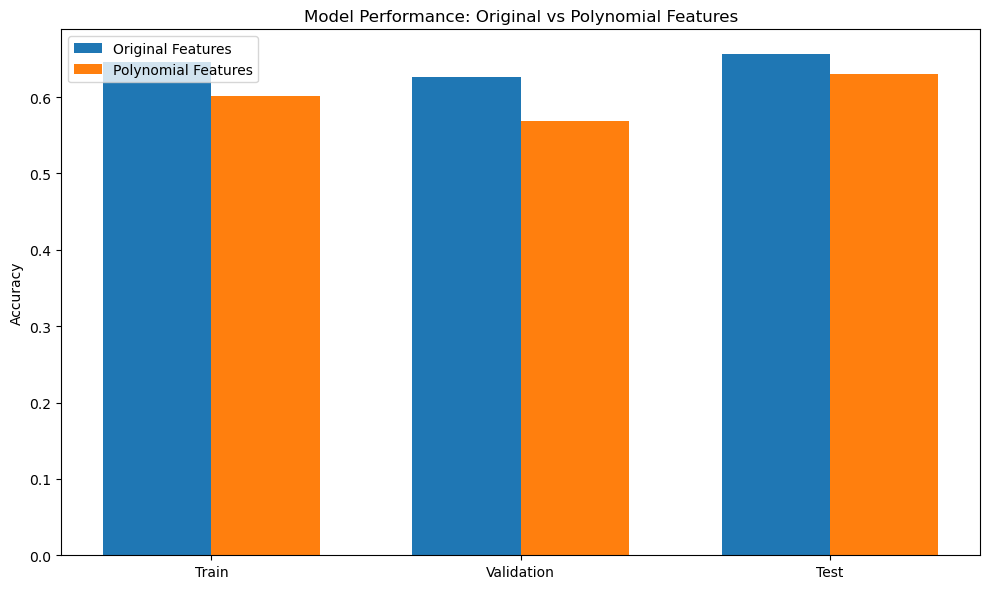

In [41]:

# Original Features
X_train_orig, X_val_orig, X_test_orig, y_train, y_val, y_test = split_data(features, target)

# Polynomial Features
X_poly, poly_feature_names = generate_polynomial_features(features, degree=2)
X_train_poly, X_val_poly, X_test_poly, _, _, _ = split_data(X_poly, target)

# Train models
model_orig = Perceptron(learning_rate=0.01, n_iterations=1000, batch_size=32)
model_orig.fit(X_train_orig, y_train)

model_poly = Perceptron(learning_rate=0.01, n_iterations=1000, batch_size=32)
model_poly.fit(X_train_poly, y_train)

# Evaluate models
orig_train_acc = model_orig.score(X_train_orig, y_train)
orig_val_acc = model_orig.score(X_val_orig, y_val)
orig_test_acc = model_orig.score(X_test_orig, y_test)

poly_train_acc = model_poly.score(X_train_poly, y_train)
poly_val_acc = model_poly.score(X_val_poly, y_val)
poly_test_acc = model_poly.score(X_test_poly, y_test)

print("Original Features:")
print(f"Train Accuracy: {orig_train_acc:.4f}")
print(f"Validation Accuracy: {orig_val_acc:.4f}")
print(f"Test Accuracy: {orig_test_acc:.4f}")

print("\nPolynomial Features:")
print(f"Train Accuracy: {poly_train_acc:.4f}")
print(f"Validation Accuracy: {poly_val_acc:.4f}")
print(f"Test Accuracy: {poly_test_acc:.4f}")

# Visualize comparison
labels = ['Train', 'Validation', 'Test']
orig_scores = [orig_train_acc, orig_val_acc, orig_test_acc]
poly_scores = [poly_train_acc, poly_val_acc, poly_test_acc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, orig_scores, width, label='Original Features')
rects2 = ax.bar(x + width/2, poly_scores, width, label='Polynomial Features')

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance: Original vs Polynomial Features')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### 8.2 With and Without Hyperparameter Tuning Comparison


Without Hyperparameter Tuning:
Train Accuracy: 0.7169
Validation Accuracy: 0.6504
Test Accuracy: 0.6688

With Hyperparameter Tuning:
Best Parameters: {'learning_rate': 0.0001, 'batch_size': 1, 'n_iterations': 500}
Train Accuracy: 0.7210
Validation Accuracy: 0.6260
Test Accuracy: 0.6948


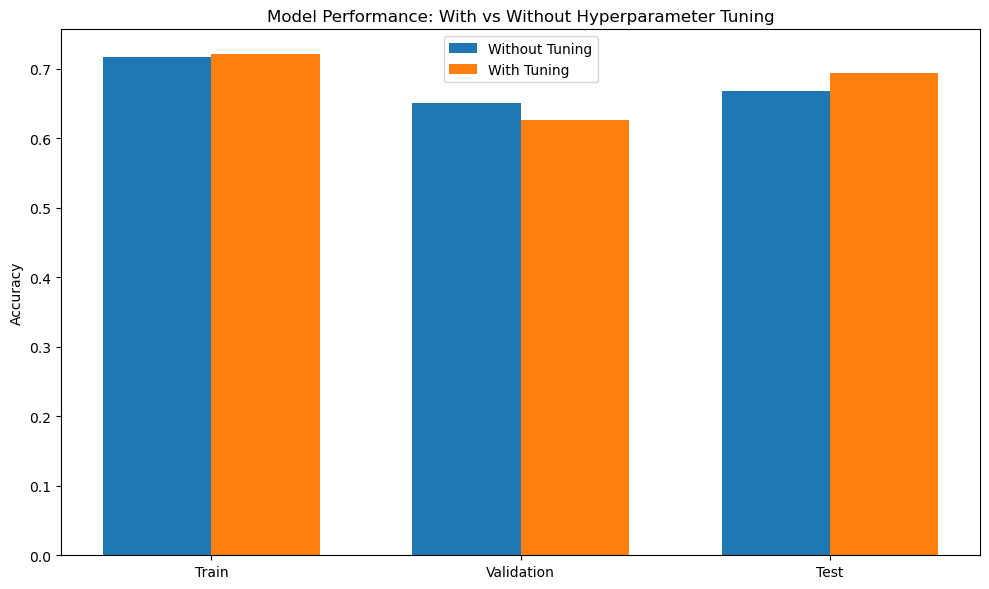

In [42]:
# Without hyperparameter tuning
model_no_tuning = Perceptron(learning_rate=0.01, n_iterations=1000, batch_size=32)
model_no_tuning.fit(X_train_orig, y_train)

# # With hyperparameter tuning
# def hyperparameter_tuning(X_train, y_train, X_val, y_val):
#     learning_rates = [0.001, 0.01, 0.1]
#     batch_sizes = [16, 32, 64]
#     n_iterations_list = [500, 1000, 1500]
    
#     best_val_acc = 0
#     best_params = {}
    
#     for lr in learning_rates:
#         for bs in batch_sizes:
#             for n_iter in n_iterations_list:
#                 model = Perceptron(learning_rate=lr, n_iterations=n_iter, batch_size=bs)
#                 model.fit(X_train, y_train)
#                 val_acc = model.score(X_val, y_val)
                
#                 if val_acc > best_val_acc:
#                     best_val_acc = val_acc
#                     best_params = {'learning_rate': lr, 'n_iterations': n_iter, 'batch_size': bs}
    
#     return best_params

#best_params = hyperparameter_tuning(X_train_orig, y_train, X_val_orig, y_val)
model_tuned = Perceptron(**best_params)
model_tuned.fit(X_train_orig, y_train)

# Evaluate models
no_tuning_train_acc = model_no_tuning.score(X_train_orig, y_train)
no_tuning_val_acc = model_no_tuning.score(X_val_orig, y_val)
no_tuning_test_acc = model_no_tuning.score(X_test_orig, y_test)

tuned_train_acc = model_tuned.score(X_train_orig, y_train)
tuned_val_acc = model_tuned.score(X_val_orig, y_val)
tuned_test_acc = model_tuned.score(X_test_orig, y_test)

print("Without Hyperparameter Tuning:")
print(f"Train Accuracy: {no_tuning_train_acc:.4f}")
print(f"Validation Accuracy: {no_tuning_val_acc:.4f}")
print(f"Test Accuracy: {no_tuning_test_acc:.4f}")

print("\nWith Hyperparameter Tuning:")
print(f"Best Parameters: {best_params}")
print(f"Train Accuracy: {tuned_train_acc:.4f}")
print(f"Validation Accuracy: {tuned_val_acc:.4f}")
print(f"Test Accuracy: {tuned_test_acc:.4f}")

# Visualize comparison
labels = ['Train', 'Validation', 'Test']
no_tuning_scores = [no_tuning_train_acc, no_tuning_val_acc, no_tuning_test_acc]
tuned_scores = [tuned_train_acc, tuned_val_acc, tuned_test_acc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, no_tuning_scores, width, label='Without Tuning')
rects2 = ax.bar(x + width/2, tuned_scores, width, label='With Tuning')

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance: With vs Without Hyperparameter Tuning')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()